Краткие результаты:

1)В работе проведено разделение картины Мона Лиза на две части. Левая изменена под стиль Мунк, картина крик, правая - под картинку Пикассо. 

2) В работе сделан одновременный перенос стилей на картину Мона Лиза упомянутых картин с различными весами (от 0 до 1 с шагом 0.1)

###РАЗДЕЛЕНИЕ КАРТИНКИ НА ДВЕ ЧАСТИ

In [ ]:
%matplotlib inline
from PIL import Image


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt


import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
imsize = 128  

loader = transforms.Compose([
    transforms.Resize(imsize),  # нормируем размер изображения
    transforms.CenterCrop(imsize),
    transforms.ToTensor()])  # превращаем в удобный формат

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img1 = image_loader("/content/drive/My Drive/images/picasso.jpg")# as well as here
style_img2 = image_loader("/content/drive/My Drive/images/60055B.jpg")# as well as here
content_img = image_loader("/content/drive/My Drive/images/lisa.jpg")#измените путь на тот который у вас.

Выведем первоначальные изображения

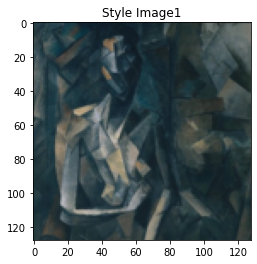

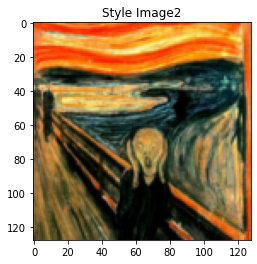

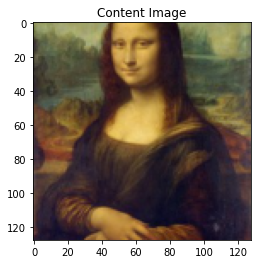

In [ ]:
unloader = transforms.ToPILImage() # тензор в кратинку  

plt.ion() 

def imshow(tensor, title=None):
    image = tensor.cpu().clone()   
    image = image.squeeze(0)      # функция для отрисовки изображения
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

# отрисовка

plt.figure()
imshow(style_img1, title='Style Image1')

plt.figure()
imshow(style_img2, title='Style Image2')

plt.figure()
imshow(content_img, title='Content Image')

In [ ]:
class ContentLoss(nn.Module):

        def __init__(self, target,):
            super(ContentLoss, self).__init__()
            # we 'detach' the target content from the tree used
            # to dynamically compute the gradient: this is a stated value,
            # not a variable. Otherwise the forward method of the criterion
            # will throw an error.
            self.target = target.detach()#это константа. Убираем ее из дерева вычеслений
            self.loss = F.mse_loss(self.target, self.target )#to initialize with something

        def forward(self, input):
            self.loss = F.mse_loss(input, self.target)
            return input

In [ ]:
def gram_matrix(input):
        batch_size , h, w, f_map_num = input.size()  # batch size(=1)
        # b=number of feature maps
        # (h,w)=dimensions of a feature map (N=h*w)

        features = input.view(batch_size * h, w * f_map_num)  # resise F_XL into \hat F_XL

        G = torch.mm(features, features.t())  # compute the gram product

        # we 'normalize' the values of the gram matrix
        # by dividing by the number of element in each feature maps.
        return G.div(batch_size * h * w * f_map_num)

Изменим StyleLos. Применим маску к выходу предобученной сети VGG, на вход которой подавались две картинки с двумя стилями. Т.е. изменим self.target1 and self.target2, сделав нули на левой или правой части соотвественно. В функции forward сделаем два тензора размерности что и input, но также с нулями в правой и левой части соотвественно. Посчитаем две матрицы Грама, посчитаем две ошибки и сложим с одинаковыми весами.

In [ ]:
class StyleLoss(nn.Module):
        def __init__(self, target_feature1, target_feature2):
            super(StyleLoss, self).__init__()
            self.mask1 = torch.ones_like(target_feature1)
            self.mask1[:,:,:,:self.mask1.shape[3] // 2] = 0
            self.target1 = gram_matrix(target_feature1*self.mask1).detach()
            self.mask2 = torch.ones_like(target_feature2)
            self.mask2[:,:,:,self.mask1.shape[3] // 2:] = 0
            self.target2 = gram_matrix(target_feature2*self.mask2).detach()

        def forward(self, input):
            input2_1 = torch.ones_like(input)
            input2_1[:,:,:,:input2_1.shape[3] // 2] = 0
            input2_2 = torch.ones_like(input)
            input2_2[:,:,:,input2_2.shape[3] // 2:] = 0
            G1 = gram_matrix(input*input2_1)
            G2 = gram_matrix(input*input2_2)
            #G = gram_matrix(input)
            self.loss = F.mse_loss(G1, self.target1) + F.mse_loss(G2, self.target2)
            return input

In [ ]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

In [ ]:
class Normalization(nn.Module):
        def __init__(self, mean, std):
            super(Normalization, self).__init__()
            # .view the mean and std to make them [C x 1 x 1] so that they can
            # directly work with image Tensor of shape [B x C x H x W].
            # B is batch size. C is number of channels. H is height and W is width.
            self.mean = torch.tensor(mean).view(-1, 1, 1)
            self.std = torch.tensor(std).view(-1, 1, 1)

        def forward(self, img):
            # normalize img
            return (img - self.mean) / self.std

In [57]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

In [ ]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth


In [ ]:
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                                   style_img1, style_img2, content_img,
                                   content_layers=content_layers_default,
                                   style_layers=style_layers_default):
        cnn = copy.deepcopy(cnn)

        # normalization module
        normalization = Normalization(normalization_mean, normalization_std).to(device)

        # just in order to have an iterable access to or list of content/syle
        # losses
        content_losses = []
        style_losses = []

        # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
        # to put in modules that are supposed to be activated sequentially
        model = nn.Sequential(normalization)

        i = 0  # increment every time we see a conv
        for layer in cnn.children():
            if isinstance(layer, nn.Conv2d):
                i += 1
                name = 'conv_{}'.format(i)
            elif isinstance(layer, nn.ReLU):
                name = 'relu_{}'.format(i)
                # The in-place version doesn't play very nicely with the ContentLoss
                # and StyleLoss we insert below. So we replace with out-of-place
                # ones here.
                #Переопределим relu уровень
                layer = nn.ReLU(inplace=False)
            elif isinstance(layer, nn.MaxPool2d):
                name = 'pool_{}'.format(i)
            elif isinstance(layer, nn.BatchNorm2d):
                name = 'bn_{}'.format(i)
            else:
                raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

            model.add_module(name, layer)

            if name in content_layers:
                # add content loss:
                target = model(content_img).detach()
                content_loss = ContentLoss(target)
                model.add_module("content_loss_{}".format(i), content_loss)
                content_losses.append(content_loss)

            if name in style_layers:
                # add style loss:
                target_feature1 = model(style_img1).detach()
                target_feature2 = model(style_img2).detach()
                style_loss = StyleLoss(target_feature1, target_feature2)
                model.add_module("style_loss_{}".format(i), style_loss)
                style_losses.append(style_loss)

        # now we trim off the layers after the last content and style losses
        #выбрасываем все уровни после последенего styel loss или content loss
        for i in range(len(model) - 1, -1, -1):
            if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
                break

        model = model[:(i + 1)]

        return model, style_losses, content_losses

In [ ]:
def get_input_optimizer(input_img):
        # this line to show that input is a parameter that requires a gradient
        #добоваляет содержимое тензора катринки в список изменяемых оптимизатором параметров
        optimizer = optim.LBFGS([input_img.requires_grad_()]) 
        return optimizer

In [ ]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                        content_img, style_img1, style_img2, input_img, num_steps=500,
                        style_weight=100000, content_weight=1):
        """Run the style transfer."""
        print('Building the style transfer model..')
        model, style_losses, content_losses = get_style_model_and_losses(cnn,
            normalization_mean, normalization_std, style_img1, style_img2, content_img)
        optimizer = get_input_optimizer(input_img)

        print('Optimizing..')
        run = [0]
        while run[0] <= num_steps:

            def closure():
                # correct the values 
                # это для того, чтобы значения тензора картинки не выходили за пределы [0;1]
                input_img.data.clamp_(0, 1)

                optimizer.zero_grad()

                model(input_img)

                style_score = 0
                content_score = 0

                for sl in style_losses:
                    style_score += sl.loss
                for cl in content_losses:
                    content_score += cl.loss
                
                #взвешивание ощибки
                style_score *= style_weight
                content_score *= content_weight

                loss = style_score + content_score
                loss.backward()

                run[0] += 1
                if run[0] % 50 == 0:
                    print("run {}:".format(run))
                    print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                        style_score.item(), content_score.item()))
                    print()

                return style_score + content_score

            optimizer.step(closure)

        # a last correction...
        input_img.data.clamp_(0, 1)

        return input_img

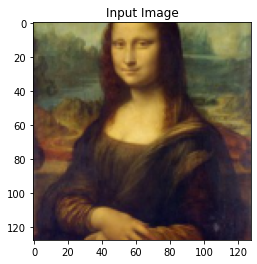

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


run [50]:
Style Loss : 30.303101 Content Loss: 28.238045

run [100]:
Style Loss : 11.956182 Content Loss: 23.076027

run [150]:
Style Loss : 7.496798 Content Loss: 20.361923

run [200]:
Style Loss : 5.951643 Content Loss: 18.979811

run [250]:
Style Loss : 5.287216 Content Loss: 18.185070

run [300]:
Style Loss : 5.116282 Content Loss: 17.739590

run [350]:
Style Loss : 4.696162 Content Loss: 17.378292

run [400]:
Style Loss : 7.456574 Content Loss: 17.005493

run [450]:
Style Loss : 5.154349 Content Loss: 17.589867

run [500]:
Style Loss : 8.209658 Content Loss: 17.216209



In [ ]:
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img1, style_img2, input_img)

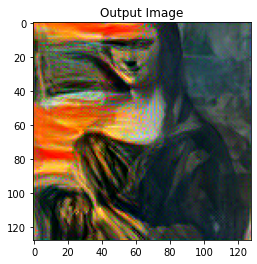

In [ ]:
plt.figure()
imshow(output, title='Output Image')
#plt.imsave(output, 'output.png')
# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

Видно, что картинка разделена на две части. В левой виден стиль Мунка с картины "Крик", в правой - стиль картины Пикассо

###КОМБИНАЦИЯ СТИЛЕЙ

Теперь изменим StyleLoss таким образом, что будет один self.target, который будет суммой с self.target1 and self.target2 с различными весами. И ошибка будет считаться по этому self.target. При этом вес можно менять при вызове функции

In [ ]:
class StyleLoss(nn.Module):
        def __init__(self, target_feature1, target_feature2, alpha):
            super(StyleLoss, self).__init__()
            self.target1 = gram_matrix(target_feature1).detach()
            self.target2 = gram_matrix(target_feature2).detach()
            self.target = alpha*self.target1 + (1-alpha)*self.target2

        def forward(self, input):
            G = gram_matrix(input)
            self.loss = F.mse_loss(G, self.target)# + F.mse_loss(G, self.target2))/2
            return input

Внесем альфа в перменные при вызове функции

In [ ]:
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                                   style_img1, style_img2, alpha, content_img,
                                   content_layers=content_layers_default,
                                   style_layers=style_layers_default):
        cnn = copy.deepcopy(cnn)

        # normalization module
        normalization = Normalization(normalization_mean, normalization_std).to(device)

        # just in order to have an iterable access to or list of content/syle
        # losses
        content_losses = []
        style_losses = []

        # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
        # to put in modules that are supposed to be activated sequentially
        model = nn.Sequential(normalization)

        i = 0  # increment every time we see a conv
        for layer in cnn.children():
            if isinstance(layer, nn.Conv2d):
                i += 1
                name = 'conv_{}'.format(i)
            elif isinstance(layer, nn.ReLU):
                name = 'relu_{}'.format(i)
                # The in-place version doesn't play very nicely with the ContentLoss
                # and StyleLoss we insert below. So we replace with out-of-place
                # ones here.
                #Переопределим relu уровень
                layer = nn.ReLU(inplace=False)
            elif isinstance(layer, nn.MaxPool2d):
                name = 'pool_{}'.format(i)
            elif isinstance(layer, nn.BatchNorm2d):
                name = 'bn_{}'.format(i)
            else:
                raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

            model.add_module(name, layer)

            if name in content_layers:
                # add content loss:
                target = model(content_img).detach()
                content_loss = ContentLoss(target)
                model.add_module("content_loss_{}".format(i), content_loss)
                content_losses.append(content_loss)

            if name in style_layers:
                # add style loss:
                target_feature1 = model(style_img1).detach()
                target_feature2 = model(style_img2).detach()
                style_loss = StyleLoss(target_feature1, target_feature2, alpha)
                model.add_module("style_loss_{}".format(i), style_loss)
                style_losses.append(style_loss)

        # now we trim off the layers after the last content and style losses
        #выбрасываем все уровни после последенего styel loss или content loss
        for i in range(len(model) - 1, -1, -1):
            if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
                break

        model = model[:(i + 1)]

        return model, style_losses, content_losses

In [ ]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                        content_img, style_img1, style_img2, alpha, input_img, num_steps=500,
                        style_weight=100000, content_weight=1):
        """Run the style transfer."""
        print('Building the style transfer model..')
        model, style_losses, content_losses = get_style_model_and_losses(cnn,
            normalization_mean, normalization_std, style_img1, style_img2, alpha, content_img)
        optimizer = get_input_optimizer(input_img)

        print('Optimizing..')
        run = [0]
        while run[0] <= num_steps:

            def closure():
                # correct the values 
                # это для того, чтобы значения тензора картинки не выходили за пределы [0;1]
                input_img.data.clamp_(0, 1)

                optimizer.zero_grad()

                model(input_img)

                style_score = 0
                content_score = 0

                for sl in style_losses:
                    style_score += sl.loss
                for cl in content_losses:
                    content_score += cl.loss
                
                #взвешивание ощибки
                style_score *= style_weight
                content_score *= content_weight

                loss = style_score + content_score
                loss.backward()

                run[0] += 1
                if run[0] % 50 == 0:
                    print("run {}:".format(run))
                    print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                        style_score.item(), content_score.item()))
                    print()

                return style_score + content_score

            optimizer.step(closure)

        # a last correction...
        input_img.data.clamp_(0, 1)

        return input_img

Вызовем обучении сети при различных весах для каждой картинки

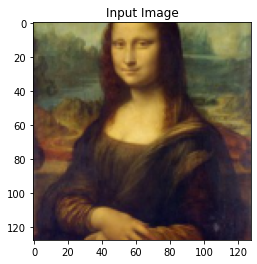

0.0
Building the style transfer model..
Optimizing..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


run [50]:
Style Loss : 109.315094 Content Loss: 55.157410

run [100]:
Style Loss : 30.340393 Content Loss: 49.298134

run [150]:
Style Loss : 14.274054 Content Loss: 43.570038

run [200]:
Style Loss : 9.302365 Content Loss: 38.796753

run [250]:
Style Loss : 7.032308 Content Loss: 35.707748

run [300]:
Style Loss : 5.986352 Content Loss: 33.436241

run [350]:
Style Loss : 5.199454 Content Loss: 31.780697

run [400]:
Style Loss : 5.102251 Content Loss: 30.444031

run [450]:
Style Loss : 5.236371 Content Loss: 29.605982

run [500]:
Style Loss : 4.687204 Content Loss: 29.250044



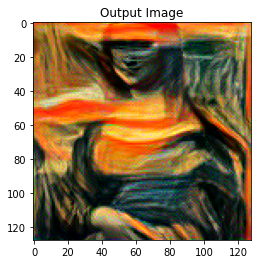

0.1
Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 3.600291 Content Loss: 25.505514

run [100]:
Style Loss : 3.564862 Content Loss: 24.893957

run [150]:
Style Loss : 3.627901 Content Loss: 24.631336

run [200]:
Style Loss : 3.805933 Content Loss: 24.528412

run [250]:
Style Loss : 4.904123 Content Loss: 24.438198

run [300]:
Style Loss : 77.674232 Content Loss: 37.827675

run [350]:
Style Loss : 10.141891 Content Loss: 31.479797

run [400]:
Style Loss : 5.683825 Content Loss: 27.259617

run [450]:
Style Loss : 4.414056 Content Loss: 25.188595

run [500]:
Style Loss : 3.915559 Content Loss: 24.290302



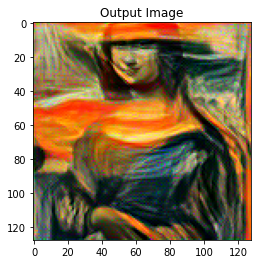

0.2
Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 3.403245 Content Loss: 21.130785

run [100]:
Style Loss : 3.229044 Content Loss: 20.688366

run [150]:
Style Loss : 3.304346 Content Loss: 20.460346

run [200]:
Style Loss : 3.303377 Content Loss: 20.456640

run [250]:
Style Loss : 1935635.000000 Content Loss: 437.290527

run [300]:
Style Loss : 653.056885 Content Loss: 47.846146

run [350]:
Style Loss : 49.616211 Content Loss: 46.588539

run [400]:
Style Loss : 21.395149 Content Loss: 40.146873

run [450]:
Style Loss : 12.043393 Content Loss: 35.148224

run [500]:
Style Loss : 7.974011 Content Loss: 31.676460



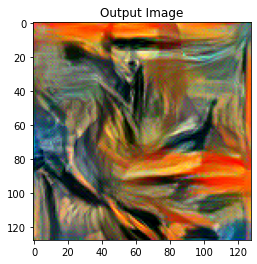

0.3
Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 6.166588 Content Loss: 26.036175

run [100]:
Style Loss : 5.285505 Content Loss: 24.091084

run [150]:
Style Loss : 4.540472 Content Loss: 22.640688

run [200]:
Style Loss : 4.115774 Content Loss: 21.623363

run [250]:
Style Loss : 3.905618 Content Loss: 20.852858

run [300]:
Style Loss : 3.622931 Content Loss: 20.389862

run [350]:
Style Loss : 3.564727 Content Loss: 19.982687

run [400]:
Style Loss : 3.632702 Content Loss: 19.809958

run [450]:
Style Loss : 3.807618 Content Loss: 20.016798

run [500]:
Style Loss : 3.721183 Content Loss: 19.789864



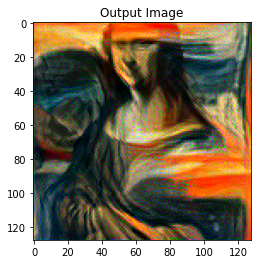

0.4
Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 3.184164 Content Loss: 16.761818

run [100]:
Style Loss : 2.912603 Content Loss: 16.299507

run [150]:
Style Loss : 2.937250 Content Loss: 16.117577

run [200]:
Style Loss : 3.197918 Content Loss: 16.015108

run [250]:
Style Loss : 3.557187 Content Loss: 16.307671

run [300]:
Style Loss : 3.627907 Content Loss: 16.403004

run [350]:
Style Loss : 3.615276 Content Loss: 16.503626

run [400]:
Style Loss : 6.830896 Content Loss: 18.730076

run [450]:
Style Loss : 5.061652 Content Loss: 17.147341

run [500]:
Style Loss : 2936603.500000 Content Loss: 524.682617



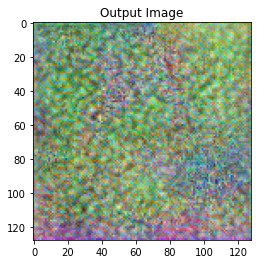

0.5
Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 46.306503 Content Loss: 40.282677

run [100]:
Style Loss : 21.438198 Content Loss: 33.257729

run [150]:
Style Loss : 11.697930 Content Loss: 27.662302

run [200]:
Style Loss : 7.387540 Content Loss: 22.965466

run [250]:
Style Loss : 5.171056 Content Loss: 19.487638

run [300]:
Style Loss : 3.985743 Content Loss: 17.457958

run [350]:
Style Loss : 3.327990 Content Loss: 16.091740

run [400]:
Style Loss : 3.143636 Content Loss: 14.998021

run [450]:
Style Loss : 2.909884 Content Loss: 14.312794

run [500]:
Style Loss : 2.838232 Content Loss: 13.884319



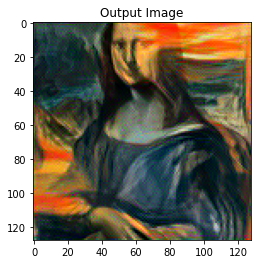

0.6
Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 2.517577 Content Loss: 11.419491

run [100]:
Style Loss : 2.394189 Content Loss: 11.112391

run [150]:
Style Loss : 2.463024 Content Loss: 10.988132

run [200]:
Style Loss : 2.512381 Content Loss: 10.959037

run [250]:
Style Loss : 2.713330 Content Loss: 11.024755

run [300]:
Style Loss : 2.624895 Content Loss: 11.074723

run [350]:
Style Loss : 2.641581 Content Loss: 10.937303

run [400]:
Style Loss : 3.289576 Content Loss: 11.535631

run [450]:
Style Loss : 3.506693 Content Loss: 11.032719

run [500]:
Style Loss : 3.251127 Content Loss: 10.895424



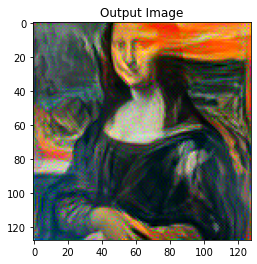

0.7
Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 2.522371 Content Loss: 8.737137

run [100]:
Style Loss : 2.256919 Content Loss: 8.438472

run [150]:
Style Loss : 2.094402 Content Loss: 8.317659

run [200]:
Style Loss : 2.032671 Content Loss: 8.254353

run [250]:
Style Loss : 2.017813 Content Loss: 8.246854

run [300]:
Style Loss : 2.256138 Content Loss: 8.449715

run [350]:
Style Loss : 2.069754 Content Loss: 8.337370

run [400]:
Style Loss : 3.490623 Content Loss: 9.178694

run [450]:
Style Loss : 297.315613 Content Loss: 15.621022

run [500]:
Style Loss : 2474498.500000 Content Loss: 476.276672



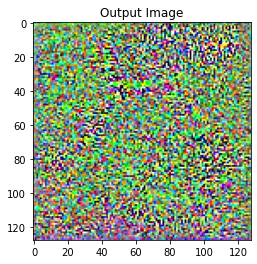

0.8
Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 31.147654 Content Loss: 27.774441

run [100]:
Style Loss : 17.460592 Content Loss: 19.333286

run [150]:
Style Loss : 11.255629 Content Loss: 13.928503

run [200]:
Style Loss : 7.087270 Content Loss: 10.907383

run [250]:
Style Loss : 4.547399 Content Loss: 9.147436

run [300]:
Style Loss : 3.295486 Content Loss: 8.060379

run [350]:
Style Loss : 2.754207 Content Loss: 7.380203

run [400]:
Style Loss : 2.476846 Content Loss: 6.993728

run [450]:
Style Loss : 2.325535 Content Loss: 6.753065

run [500]:
Style Loss : 2.252647 Content Loss: 6.556242



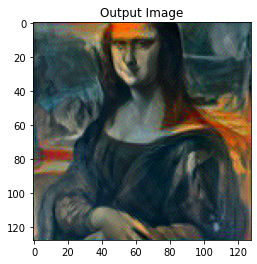

0.9
Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 1.796389 Content Loss: 5.304719

run [100]:
Style Loss : 1.670182 Content Loss: 4.994642

run [150]:
Style Loss : 1.644233 Content Loss: 4.862056

run [200]:
Style Loss : 1.620373 Content Loss: 4.793302

run [250]:
Style Loss : 1.599108 Content Loss: 4.747910

run [300]:
Style Loss : 1.581731 Content Loss: 4.717647

run [350]:
Style Loss : 1.568808 Content Loss: 4.693723

run [400]:
Style Loss : 1.557884 Content Loss: 4.675141

run [450]:
Style Loss : 1.550118 Content Loss: 4.658020

run [500]:
Style Loss : 1.551139 Content Loss: 4.638968



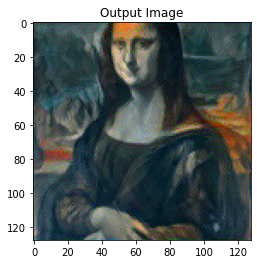

1.0
Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 1.474842 Content Loss: 4.509196

run [100]:
Style Loss : 1.179320 Content Loss: 4.243291

run [150]:
Style Loss : 1.116315 Content Loss: 4.121233

run [200]:
Style Loss : 1.086875 Content Loss: 4.078314

run [250]:
Style Loss : 1.074068 Content Loss: 4.056321

run [300]:
Style Loss : 1.065959 Content Loss: 4.043906

run [350]:
Style Loss : 1.061575 Content Loss: 4.033596

run [400]:
Style Loss : 1.059014 Content Loss: 4.024428

run [450]:
Style Loss : 1.056105 Content Loss: 4.017962

run [500]:
Style Loss : 1.054132 Content Loss: 4.012270



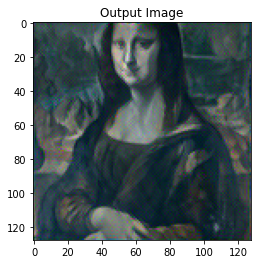

In [ ]:
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')
for i in range(11): 
    print(i / 10)   
    output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img1, style_img2, i/10, input_img)
    plt.figure()
    imshow(output, title='Output Image')
#plt.imsave(output, 'output.png')
# sphinx_gallery_thumbnail_number = 4
    plt.ioff()
    plt.show()

Видно, что стиль получаемой картинки меняется от Мунк "Крик" при альфа равном нулю, до Пикассо при альфа равном 1.